In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, Permute, BatchNormalization
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy, MaxBoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
/Users/raymond.djajalaksana/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

class DDPGEnvProcessor(EnvProcessor):
    def __init__(self, train_policy, test_policy):
        EnvProcessor.__init__(self)
        self.nb_act_count = [0,0]
        self.count = 0
        self.train_policy = train_policy
        self.test_policy = test_policy
        
    def process_action(self,actions):
        if train_mode:
            choice = self.train_policy.select_action(q_values=actions)
        else:
            choice = self.test_policy.select_action(q_values=actions)
        self.nb_act_count[choice] +=1
        self.count += 1
        if self.count % 1949 == 0:
            print(self.nb_act_count)
        if self.count % 400 == 0:
            print(actions)
            
        return choice

In [3]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 4500), window_size=window_size)

window_size = 25
env = env_creator()
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = env.action_space.n
    env_shape = (window_size,2)
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(256))
    actor.add(Activation('relu'))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

def critic_actor():
    env_shape = (window_size,2)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    obs = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Flatten()(obs)

    obs_1 = Dense(256, activation='relu')(obs)
    obs_1 = Dropout(0.2)(obs_1)
    obs_1 = Dense(64, activation='relu')(obs_1)
    obs_out = Dense(nb_actions, activation='softmax')(obs_1)
    actor = Model(inputs=[observation_input], outputs=obs_out)
    # print(actor.summary())

    obs_2 = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Flatten()(obs_2)

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(32, activation='linear')(action_input)

    x = Concatenate()([a1, obs])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    x = Activation('softmax')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    # print(critic.summary())
    return actor, critic, action_input

def agent_creator():
#     train_policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.08, value_test=0.05, nb_steps=10000)
#     test_policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.00, value_min=0.00, value_test=0.00, nb_steps=10000)
    train_policy = MaxBoltzmannQPolicy()
    test_policy = MaxBoltzmannQPolicy()
    processor = DDPGEnvProcessor(train_policy,test_policy)
    memory = SequentialMemory(limit=512, window_length=1)
    actor, critic, action_input = simple_critic_actor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                      random_process=random_process,processor=processor, gamma=1.0, 
                      batch_size=64, train_interval=32)
    agent.compile((Adam(lr=0.001),Adam(lr=0.001)), metrics=['mae'])
    train_policy._set_agent(agent)
    test_policy._set_agent(agent)
    return agent

Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
 78/889 [=>............................] - ETA: 1s - reward: 0.3513 - cumulative_reward: 69.4782         WARNING:tensorflow:From /Users/raymond.djajalaksana/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
890/889 [==============================] - 4s 5ms/step - reward: -1.2364 - cumulative_reward: -638.9357
[ 0.97326565 -0.11870824]
889/889 [==============================] - 5s 5ms/step - reward: -1.4925 - cumulative_reward: -827.3000
train 1 completed. took 5.566 seconds, total_reward: -1327.9999999999384 total_profit: 0.8414804573645284
min reward: -200.00000000000017, max reward: 93.79999999999944, mea

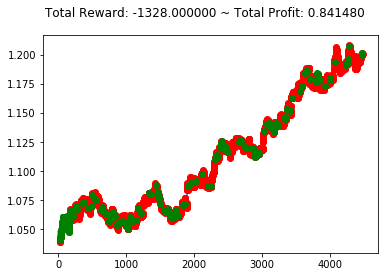

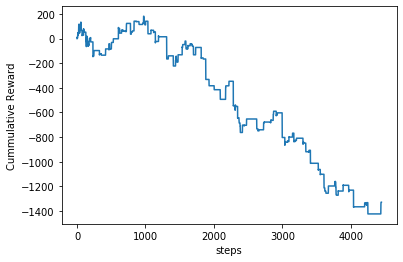

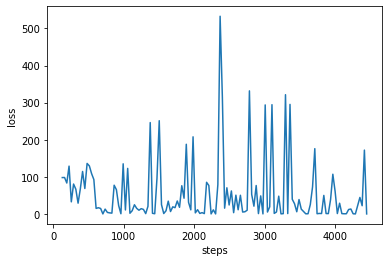

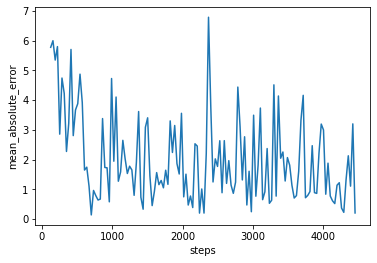

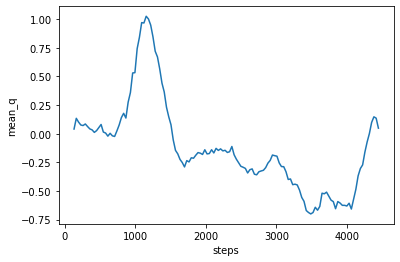

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 4s 4ms/step - reward: 0.4618 - cumulative_reward: 408.5664
[1.0817357  0.06122886]
889/889 [==============================] - 5s 5ms/step - reward: 0.0677 - cumulative_reward: 244.3559
train 2 completed. took 12.172 seconds, total_reward: 60.20000000003668 total_profit: 0.8868329809003236
min reward: -179.4999999999991, max reward: 162.5999999999994, mean_reward: 0.013531130591152322


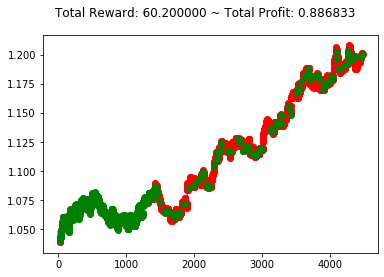

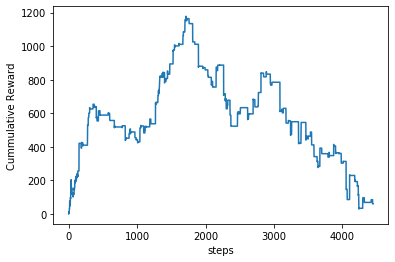

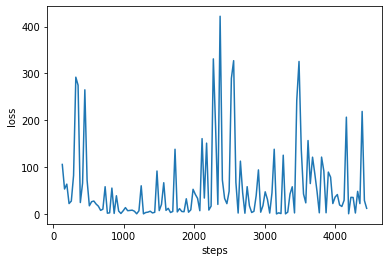

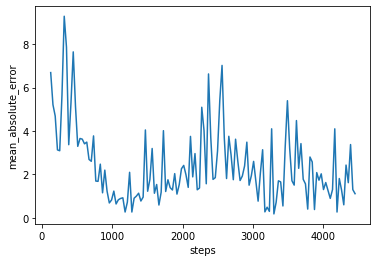

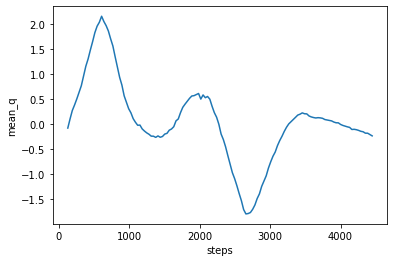

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 4s 5ms/step - reward: 0.0605 - cumulative_reward: -114.0025
[0.08606099 0.7638704 ]
889/889 [==============================] - 5s 6ms/step - reward: 0.4182 - cumulative_reward: 50.4306
train 3 completed. took 19.259 seconds, total_reward: 372.1000000000063 total_profit: 0.9072798335577502
min reward: -152.09999999999945, max reward: 131.59999999999837, mean_reward: 0.08363677230838532


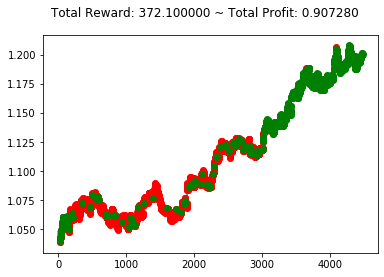

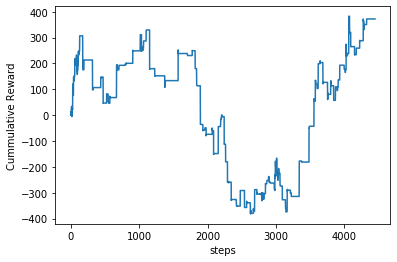

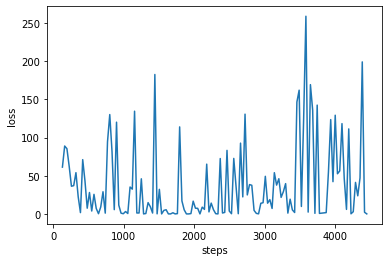

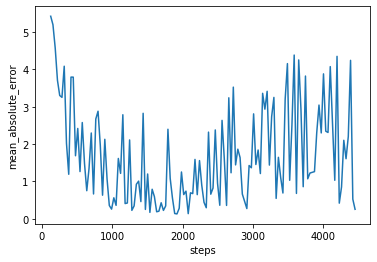

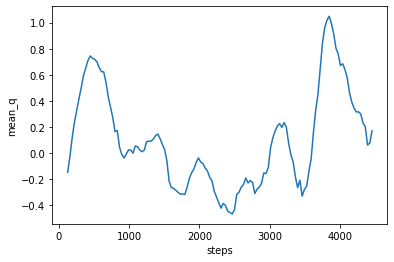

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 5s 5ms/step - reward: -0.6491 - cumulative_reward: -329.1213
[ 1.0950093  -0.03440539]
889/889 [==============================] - 6s 6ms/step - reward: -1.1061 - cumulative_reward: -553.1972
train 4 completed. took 27.212 seconds, total_reward: -984.2000000000376 total_profit: 0.860994953392599
min reward: -205.99999999999952, max reward: 195.599999999998, mean_reward: -0.22121825129243372


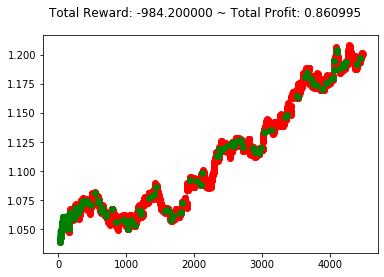

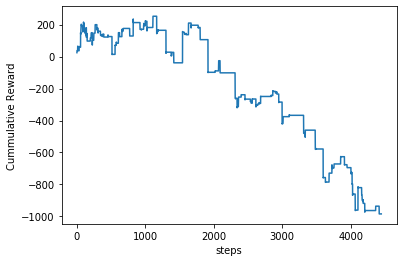

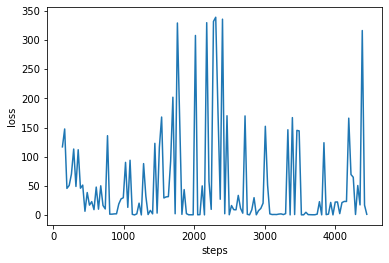

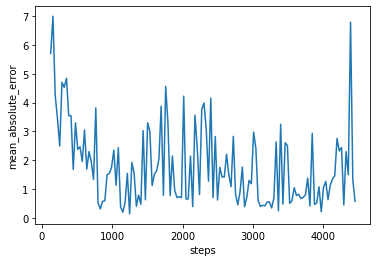

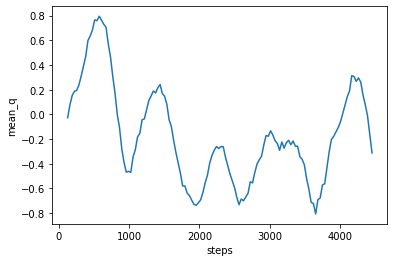

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 5s 6ms/step - reward: 0.8589 - cumulative_reward: 285.0499
[0.08676874 1.0305549 ]
889/889 [==============================] - 6s 7ms/step - reward: 1.2348 - cumulative_reward: 431.4706
train 5 completed. took 35.411 seconds, total_reward: 1098.6999999999903 total_profit: 0.9312091634636739
min reward: -182.1000000000006, max reward: 235.79999999999933, mean_reward: 0.24695437176893464


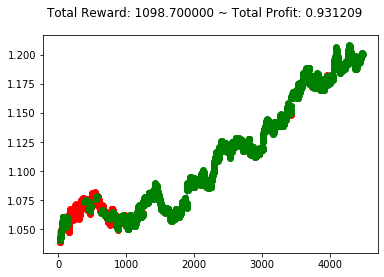

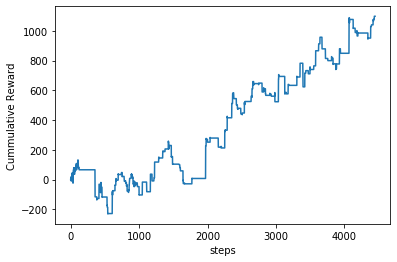

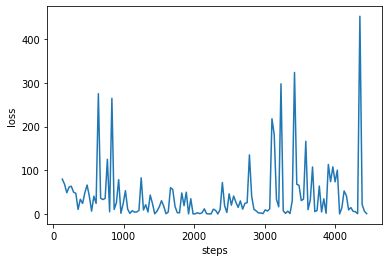

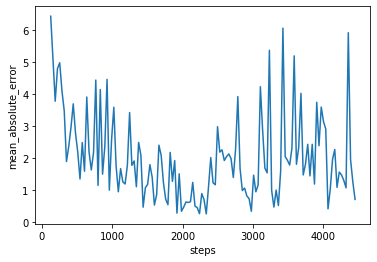

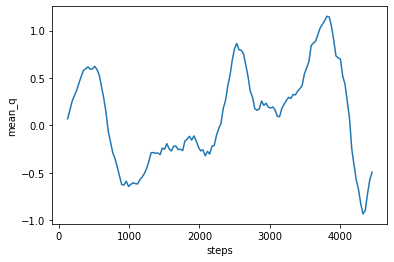

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 5s 6ms/step - reward: -1.1223 - cumulative_reward: -592.9124
[1.03544    0.03369016]
889/889 [==============================] - 6s 7ms/step - reward: -1.2596 - cumulative_reward: -626.5926
train 6 completed. took 44.931 seconds, total_reward: -1120.80000000003 total_profit: 0.8518857538718968
min reward: -176.90000000000205, max reward: 148.49999999999807, mean_reward: -0.251921780175327


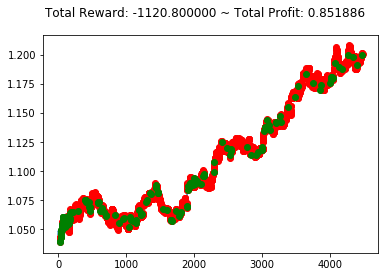

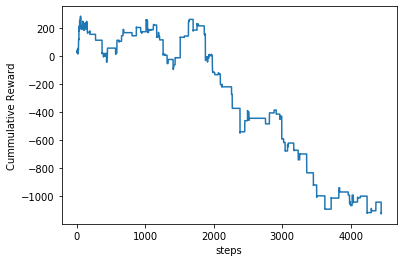

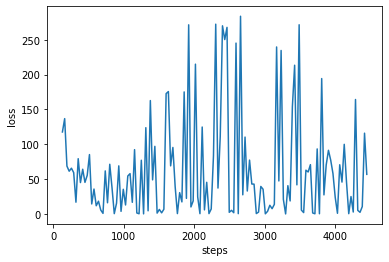

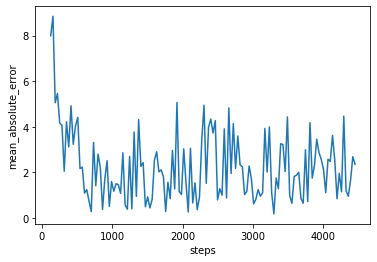

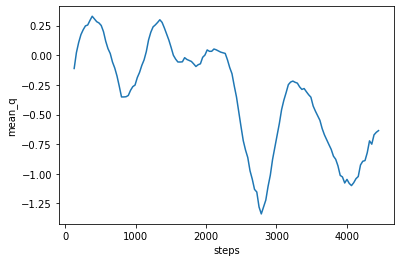

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 6s 6ms/step - reward: 7.9647 - cumulative_reward: 501.8887
[-0.00860676  0.9364197 ]
889/889 [==============================] - 7s 7ms/step - reward: 8.3468 - cumulative_reward: 637.2268
train 7 completed. took 54.533 seconds, total_reward: 1376.2999999999706 total_profit: 0.9434344911232669
min reward: -159.4999999999991, max reward: 157.4000000000031, mean_reward: 0.30935041582377404


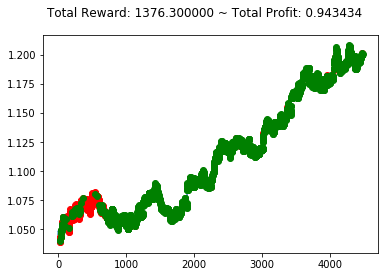

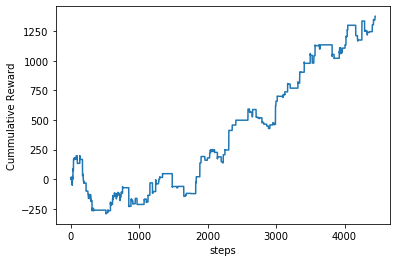

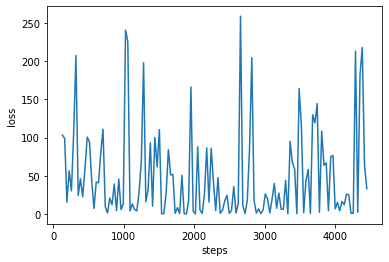

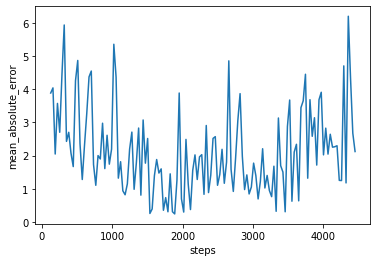

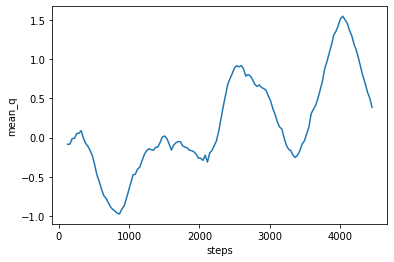

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 6s 7ms/step - reward: -1.6617 - cumulative_reward: -915.4156
[1.1541166  0.01977789]
889/889 [==============================] - 7s 8ms/step - reward: -1.7967 - cumulative_reward: -1064.9393
train 8 completed. took 65.485 seconds, total_reward: -1598.6999999999857 total_profit: 0.8264229595489095
min reward: -185.10000000000025, max reward: 145.6999999999997, mean_reward: -0.35933917734321996


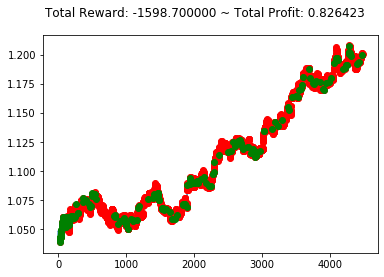

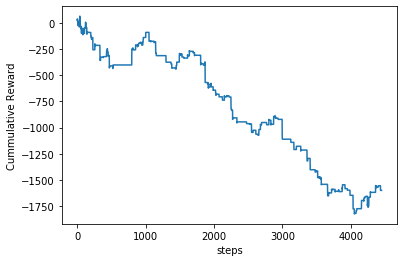

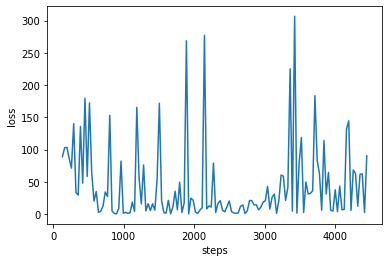

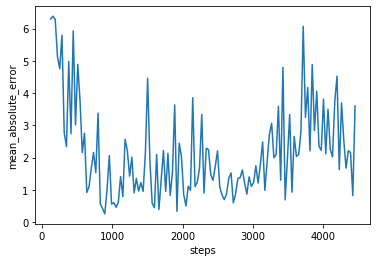

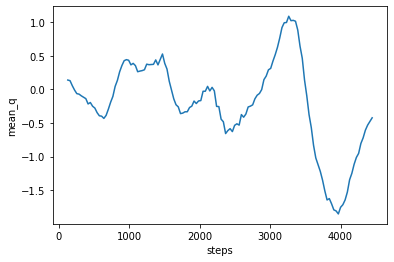

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 7s 7ms/step - reward: 0.9921 - cumulative_reward: 448.4538
[-0.02693954  0.9000874 ]
889/889 [==============================] - 8s 9ms/step - reward: 1.3029 - cumulative_reward: 616.3218
train 9 completed. took 76.610 seconds, total_reward: 1159.2999999999945 total_profit: 0.949076177707948
min reward: -134.39999999999895, max reward: 227.80000000000024, mean_reward: 0.2605754102045391


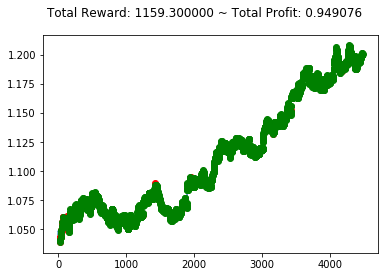

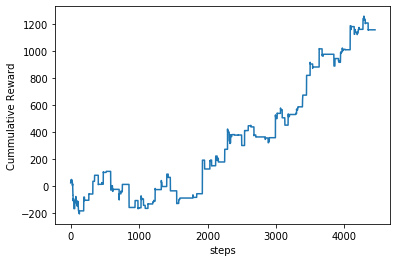

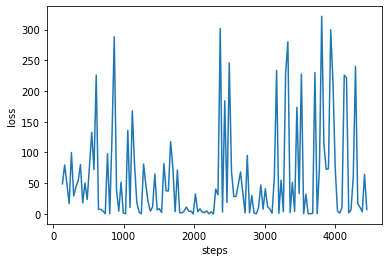

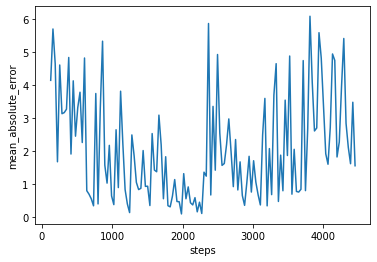

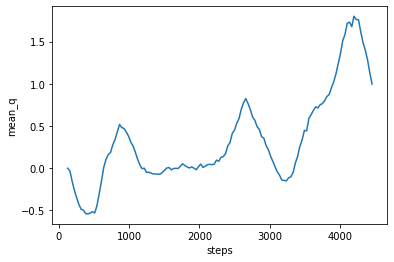

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
890/889 [==============================] - 7s 8ms/step - reward: 1.3599 - cumulative_reward: 653.4602
[0.06010281 1.0722069 ]
889/889 [==============================] - 8s 9ms/step - reward: 1.7268 - cumulative_reward: 859.6395
train 10 completed. took 88.443 seconds, total_reward: 1536.4999999999766 total_profit: 0.9598007388408647
min reward: -104.89999999999888, max reward: 329.3999999999997, mean_reward: 0.3453585075297767


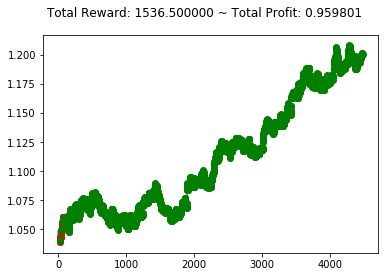

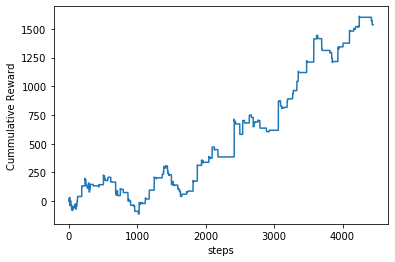

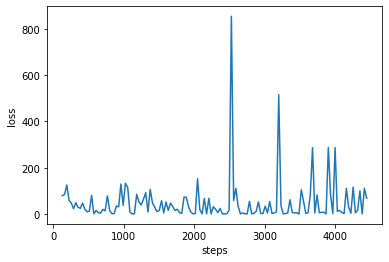

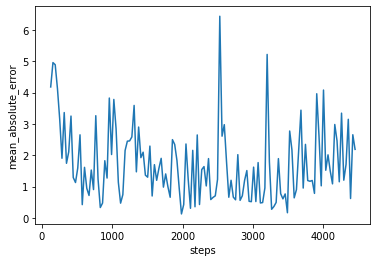

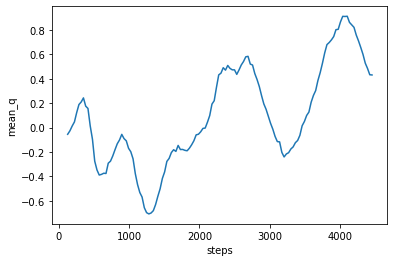

best total_rewards: 1536.4999999999766
average of total_reward across trainings: [57.14]


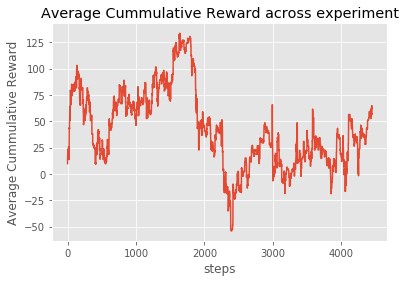

In [4]:
from evaluator import Evaluator

train_mode = True
e = Evaluator(agent_creator, env_creator, name="ddpg_greedy_512")
e.train(repeat=10)
e.process_train_result()

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
190/199 [===========================>..] - ETA: 0s - reward: -1.1399 - cumulative_reward: -38.1585Episode 1: reward: -217.500, steps: 999
test completed. total_reward: -217.49999999999284 total_profit: 0.9825497324841137
min reward: -127.3000000000013, max reward: 123.89999999999901, mean_reward: -0.21771771771771053


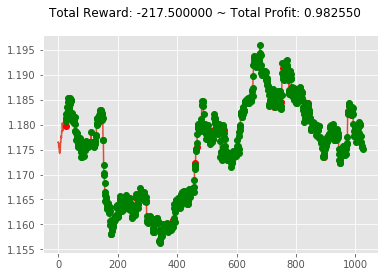

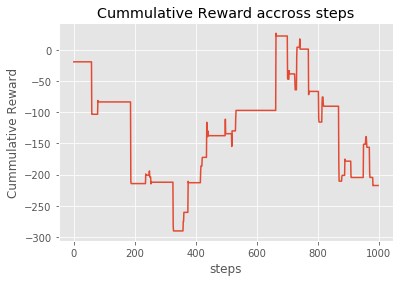

In [5]:
train_mode = False
env_test = gym.make('forex-v0', frame_bound=(5000, 6000), window_size=window_size)
e.test(env_test)

In [49]:
def test(repeat = 1):
    reward = []
    profit = []
    for i in range(repeat):
        env_test = gym.make('forex-v0', frame_bound=(5000, 6000), window_size=window_size)
        e.agent.test(env_test, visualize=False)
        reward.append(env_test._total_reward)
        profit.append(env_test._total_profit)
        env_test.render_all()
    print("average rewards : {}".format(np.mean(reward)))
    print("average rewards : {}".format(np.mean(profit)))